In [1]:
import sys
#sys.path.append('/home/yungdankblast/Desktop/Research/delay-optimizer')
sys.path.append('/home/cayjobla/Desktop/Research/delay-optimizer')
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from Optimizer_Scripts.DelayTypeGenerators import *
from Optimizer_Scripts.Data import Data

# <center> Time-Loss Plots

## Helper Functions

In [2]:
def get_filename(loss_name, d, file_tag):
    """Get the default file path and name of the specified data"""
    return f"Data/{loss_name}{d}d_{file_tag}.dat"

def load(loss_name, d, file_tag):
    """Load the specified data and return a Data object"""
    filename = get_filename(loss_name, d, file_tag)
    return Data.load(filename)

In [3]:
def get_default_color(i, meanwise=True):
    colors = ['blue', 'red', 'green', 'mediumpurple', 'gold', 'orange']
    mean_colors = ['navy', 'darkred', 'darkgreen', 'rebeccapurple', 'goldenrod', 'darkgoldenrod']
    
    if meanwise:
        return mean_colors[i]
    else:
        return colors[i]
    
    
def default_legend_colors(labels, mean_labels=False, **kwargs):
    """The default color scheme for mapping labels to tuples of color and linewidth"""
    legend_colors = {label:(get_default_color(i, False), 1.5) for i, label in enumerate(labels)}
    if mean_labels:
        legend_colors.update({"Mean "+label:(get_default_color(i), 3) for i, label in enumerate(labels)})
        
    return legend_colors

    
def create_legend(ax, labels, loc='best', assign_colors=None, **kwargs):
    """Create a legend on the given axis from the given labels.
    
    Parameters:
        ax(axis): Axis on which to create the legend
        labels(list, dict): A list of strings or a dictionary mapping strings to tuples of 
                            (color, linewidth). 
        loc(str): A location string to be passed to ax.legend()
        assign_colors(func): A function used only when passing labels as a list of strings, 
                             returning a dictionary mapping the strings in labels to tuples
                             of (color, linewidth). If None, the default function is used.
        **kwargs: Arguments to be passed to the assign_colors function
    """
    if type(labels) == dict:
        legend_colors = labels
    else:
        if assign_colors is None: assign_colors = default_legend_colors
        legend_colors = assign_colors(labels, **kwargs)
        
    lines = [(Line2D([0],[0],c=color,lw=lw), label) for label, (color, lw) in legend_colors.items()]
    ax.legend(*zip(*lines), loc=loc)
    
    return ax


def format_plot(ax, xlim=None, ylim=None, title=None, logscale=False, **kwargs):
    """Format the plot on the given axis."""
    if xlim is not None: ax.set_xlim(xlim)
    if ylim is not None: ax.set_ylim(ylim)
    if title is not None: ax.set_title(title)
    if logscale is True: ax.set_yscale("log")


def legend(labels, colors, mean_colors, pointwise, meanwise, ax, loc):
    if pointwise and meanwise:
        labels = np.ravel([[label, "Mean "+label] for label in labels])
        lines = np.ravel([[Line2D([0],[0], c=colors[i]), Line2D([0],[0], c=mean_colors[i], lw=3)] 
                          for i in range(len(colors))])
    else:
        lines = [Line2D([0],[0], c=c) for c in colors]
        if meanwise and not pointwise:
            labels = ["Mean "+label for label in labels]
    
    ax.legend(lines, labels, loc=loc)

In [8]:
def plot_time_loss(loss_name, dim, data_tags, pointwise=True, meanwise=True, ax=None, 
                   legend_loc="best", reduce=False, verbose=True, **kwargs):
    """Load the specified data and plot the loss over time of the optimization runs
    in the data loaded.
    
    Parameters:
        loss_name(str): A string denoting the loss function
        dim(int): The dimensionality of the loss function
        data_tags(dict): A mapping from string labels to string filetags of the data 
                         to plot
        pointwise(bool): Whether to plot individual point loss paths over time
        meanwise(bool): Whether to plot the mean loss value over time
        ax(axis): The axis to plot on. If None, an axis is created to plot on
        legend_loc(str): A string denoting where the legend should be created
        reduce(bool,int): If False, all points are used. If an integer, only use the
                          first `reduce` points in the plot
        verbose(bool): Whether to print learning rate parameters while plotting
        **kwargs: To be passed to the format and legend creation functions
    """
    # Initialize
    if ax is None: fig, axes = plt.subplots(1, 1, dpi=150, figsize=(8,6))
    labels, file_tags = zip(*data_tags.items())
        
    # Plot
    for i, file_tag in enumerate(file_tags):
        # Load data
        data = load(loss_name, dim, file_tag)
        loss_array = data.get_loss_array()
        if reduce is not False: loss_array = loss_array[:reduce]
        if verbose: print(f"{get_filename(loss_name, dim, file_tag)} parameters:", data.lr_params)
            
        # Define x axis values
        t = np.arange(data.maxiter+1)
    
        # Plot pointwise loss
        if pointwise is True:
            c = get_default_color(i, meanwise=False)
            for loss_path in loss_array:
                ax.plot(t, loss_path, c=c, alpha=1/255)
    
        # Plot mean loss
        if meanwise is True:
            c = get_default_color(i, meanwise=pointwise)
            lw = 1 if pointwise else 1.5
            ax.plot(t, np.mean(loss_array, axis=0), c=c, lw=lw)
                
    # Format
    format_plot(ax, xlim=[0,data.maxiter], title=f"{loss_name} {dim}d", **kwargs)
    create_legend(ax, labels, legend_loc, **kwargs)
    
    return ax


def plot_time_loss_all(loss_name, data_tags, legend_loc="best", pointwise=True, meanwise=True, 
                       reduce=False, ylimits=None, **kwargs):
    """Plot the loss over time for each of the dimensions in `dims` according to the
    data files given.
    """
    dims = [2, 10, 100, 1000]
    
    # Initialize
    fig, axes = plt.subplots(1, 4, figsize=(20,3), dpi=400)
    axes = axes.ravel()
    if type(legend_loc) != list: 
        legend_loc = [legend_loc] * len(dims)

    # Plot
    for i, d in enumerate(dims):
        ax = plot_time_loss(loss_name, d, data_tags, pointwise, meanwise, ax=axes[i], 
                            legend_loc=legend_loc[i], reduce=reduce, **kwargs)
        if ylimits is not None: format_plot(ax, ylim=ylimits[i])
        
    return axes

## Ackley

Data/Ackley2d_optimal_undel.dat parameters: {'learning_rate': 1.85721428571429, 'lr_type': 'const'}
Data/Ackley2d_optimal_stochL1.dat parameters: {'learning_rate': 1.33067690501033, 'lr_type': 'const'}
Data/Ackley10d_optimal_undel.dat parameters: {'learning_rate': 0.356360766680998, 'lr_type': 'const'}
Data/Ackley10d_optimal_stochL1.dat parameters: {'learning_rate': 1.42885714285714, 'lr_type': 'const'}
Data/Ackley100d_optimal_undel.dat parameters: {'learning_rate': 0.143927494378293, 'lr_type': 'const'}
Data/Ackley100d_optimal_stochL1.dat parameters: {'learning_rate': 1.44148801018898, 'lr_type': 'const'}
Data/Ackley1000d_optimal_undel.dat parameters: {'learning_rate': 0.087579721240169, 'lr_type': 'const'}
Data/Ackley1000d_optimal_stochL1.dat parameters: {'learning_rate': 1.40918128594683, 'lr_type': 'const'}


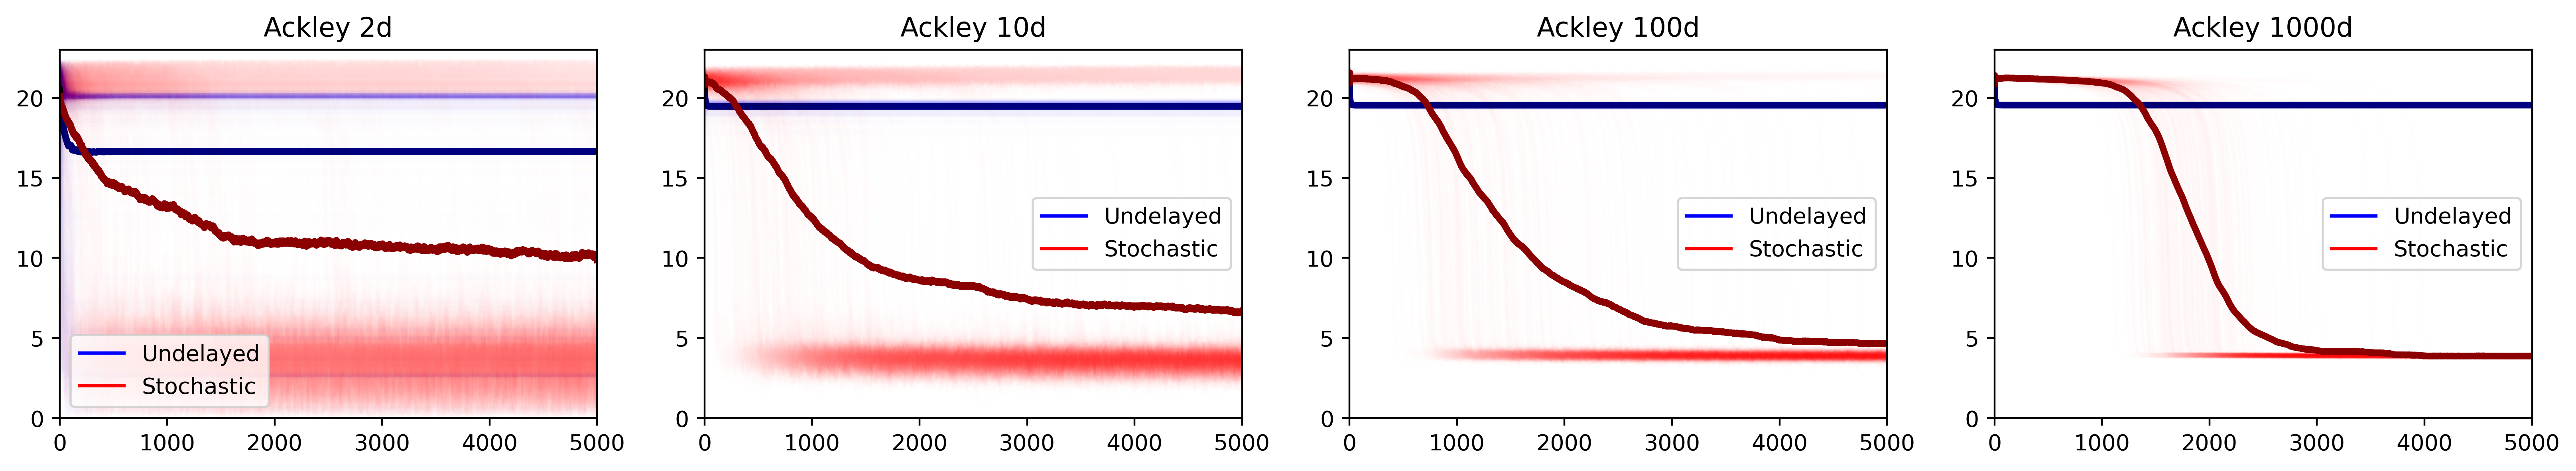

In [27]:
loss_name = "Ackley"
data_tags = {
    "Undelayed":"optimal_undel", 
    "Stochastic":"optimal_stochL1"
}
ylimits = [(0,23)] * 4
legend_locs = ["lower left", "right", "right", "right"]

plot_time_loss_all(loss_name, data_tags, legend_locs, pointwise=True, ylimits=ylimits)

plt.savefig(f"Plots/{loss_name}_time_loss.jpg", bbox_inches='tight')
plt.show()

Data/Ackley1000d_optimal_undel.dat parameters: {'learning_rate': 0.087579721240169, 'lr_type': 'const'}
Data/Ackley1000d_optimal_stochL1.dat parameters: {'learning_rate': 1.40918128594683, 'lr_type': 'const'}
Data/Ackley1000d_optimal_undel_inv.dat parameters: {'max_lr': 0.009508967272698, 'gamma': 0.899707530535596, 'p': 0.298821396485841, 'lr_type': 'inv'}
Data/Ackley1000d_optimal_stochL1_inv.dat parameters: {'max_lr': 1.89307487478717, 'gamma': 1, 'p': 0, 'lr_type': 'inv'}
Data/Ackley1000d_optimal_undel_sin2.dat parameters: {'max_lr': 0.054138088070238, 'min_lr': 0.420991121639879, 'step_size': 334.355610230797, 'lr_type': 'sin-2'}
Data/Ackley1000d_optimal_stochL1_sin2.dat parameters: {'max_lr': 2.34805588794228, 'min_lr': 0.081490557007482, 'step_size': 856.010721739515, 'lr_type': 'sin-2'}
Data/Ackley1000d_optimal_undel_tri2.dat parameters: {'max_lr': 0.471724491200333, 'min_lr': 0.196678381913816, 'step_size': 984.818801081314, 'lr_type': 'tri-2'}
Data/Ackley1000d_optimal_stochL1_

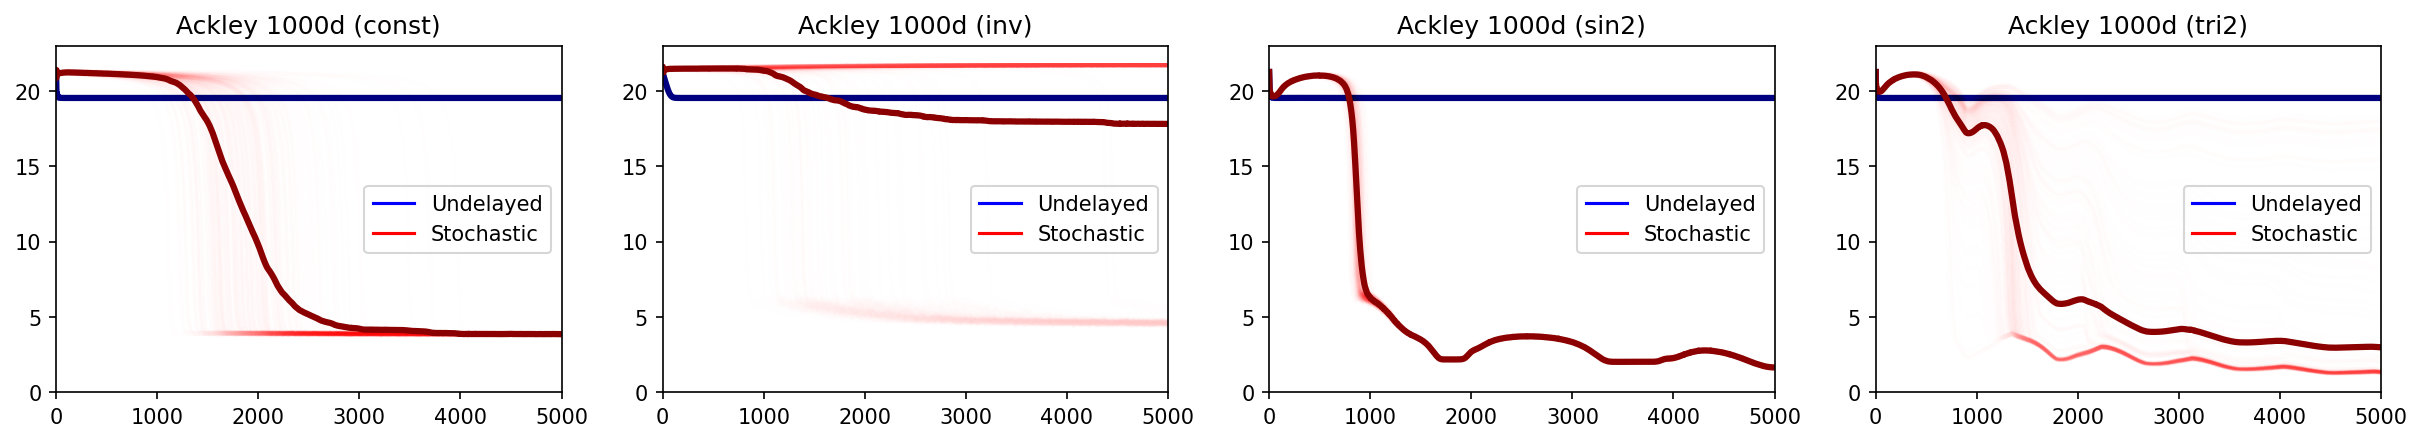

In [40]:
loss_name = "Ackley"
dim = 1000
ylim = [0,23]
fig, axes = plt.subplots(1, 4, dpi=150, figsize=(20,3))
axes = axes.ravel()

data_tags = {
    "Undelayed":"optimal_undel", 
    "Stochastic":"optimal_stochL1"
}

ax = plot_time_loss(loss_name, dim, data_tags, legend_loc="right", ax=axes[0])
format_plot(ax, ylim=ylim, title=f"{loss_name} {dim}d (const)")

lr_types = ["inv", "sin2", "tri2"]
for i, lr_type in enumerate(lr_types):
    lr_data_tags = {k:v+f"_{lr_type}" for k, v in data_tags.items()}
    ax = plot_time_loss(loss_name, dim, lr_data_tags, legend_loc="right", ax=axes[i+1])
    format_plot(ax, ylim=ylim, title=f"{loss_name} {dim}d ({lr_type})")
    
plt.savefig(f"Plots/{loss_name}_time_loss_lrs.jpg", bbox_inches='tight')
plt.show()

Undelayed Parameters: {'const_lr': True, 'learning_rate': 0.087579721240169}
Uniform Parameters: {'learning_rate': 1.40918128594683, 'lr_type': 'const'}
Stochastic Parameters: {'const_lr': True, 'learning_rate': 1.40918128594683}
Partial (25%) Parameters: {'learning_rate': 1.40918128594683, 'lr_type': 'const'}
Partial (75%) Parameters: {'learning_rate': 1.40918128594683, 'lr_type': 'const'}


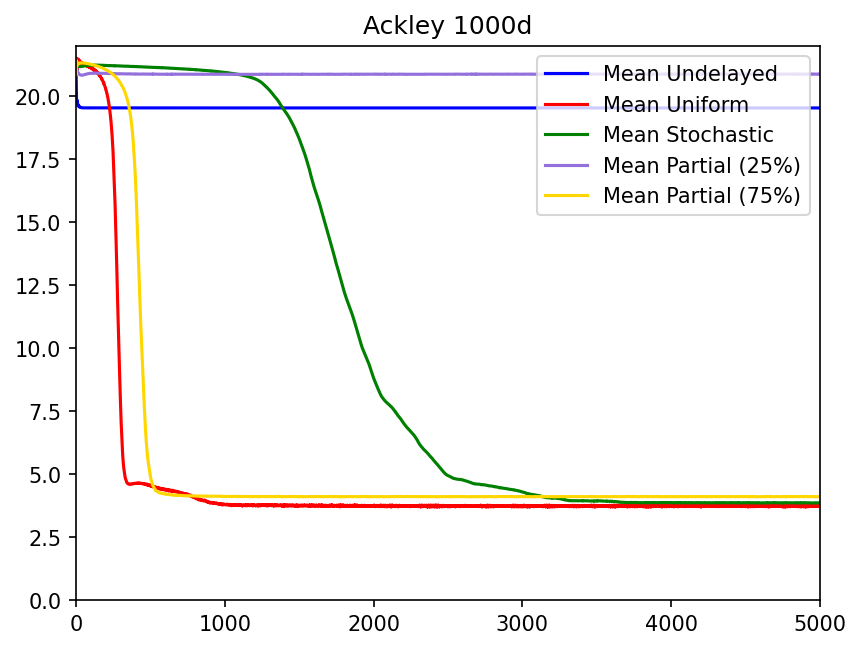

In [7]:
file_tags = ["optimal_undel", "stochL1_unifL1", "optimal_stochL1", "stochL1_part25L1", "stochL1_part75L1"]
labels = ["Undelayed", "Uniform", "Stochastic", "Partial (25%)", "Partial (75%)"]
plot_time_loss("Ackley", 1000, file_tags, labels, pointwise=False)
plt.ylim([0,22])
plt.show()

Undelayed (L=0) Parameters: {'learning_rate': 0.087579721240169, 'lr_type': 'const'}
Stochastic (T=500) Parameters: {'learning_rate': 1.40918128594683, 'lr_type': 'const'}
Stochastic (T=1000) Parameters: {'learning_rate': 1.40918128594683, 'lr_type': 'const'}
Stochastic (T=2000) Parameters: {'learning_rate': 1.40918128594683, 'lr_type': 'const'}
Stochastic (T=5000) Parameters: {'learning_rate': 1.40918128594683, 'lr_type': 'const'}


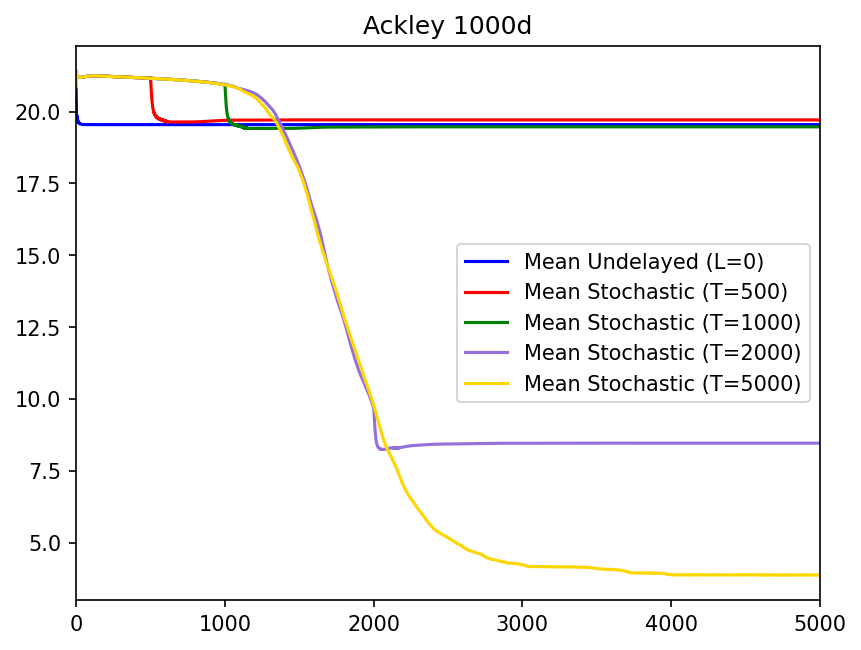

In [5]:
file_tags = ["optimal_undel", "stochL1_stochL1_500", "stochL1_stochL1_1000", "stochL1_stochL1_2000", "optimal_stochL1"]
labels = ["Undelayed", "Stochastic (T=500)", "Stochastic (T=1000)", "Stochastic (T=2000)", "Stochastic (T=5000)"]
plot_time_loss("Ackley", 1000, file_tags, labels, pointwise=False, legend_loc="right")
# plt.savefig("Plots/Ackley_time_loss_drop.png")
plt.show()

Undelayed (L=0) Parameters: {'learning_rate': 0.087579721240169, 'lr_type': 'const'}
Stochastic (L=1) Parameters: {'learning_rate': 1.40918128594683, 'lr_type': 'const'}
Stochastic (L=2) Parameters: {'learning_rate': 1.40918128594683, 'lr_type': 'const'}
Stochastic (L=5) Parameters: {'learning_rate': 1.40918128594683, 'lr_type': 'const'}
Stochastic (L=10) Parameters: {'learning_rate': 1.40918128594683, 'lr_type': 'const'}


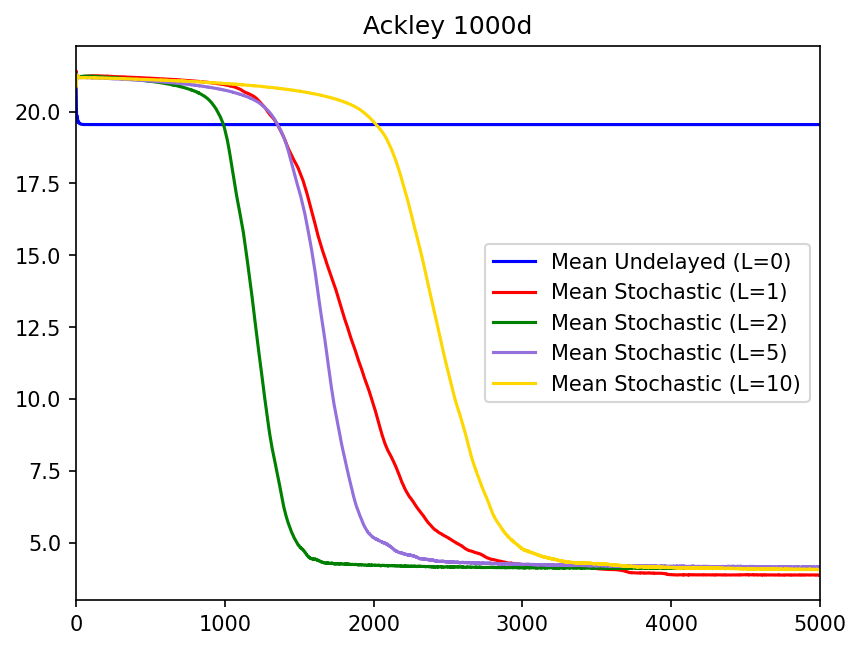

In [6]:
file_tags = ["optimal_undel", "optimal_stochL1", "stochL1_stochL2", "stochL1_stochL5", "stochL1_stochL10"]
labels = ["Undelayed (L=0)", "Stochastic (L=1)", "Stochastic (L=2)", "Stochastic (L=5)", "Stochastic (L=10)"]
plot_time_loss("Ackley", 1000, file_tags, labels, pointwise=False, legend_loc="right")
plt.savefig("Plots/Ackley_time_loss_Ls.png")
plt.show()

## Rastrigin

Data/Rastrigin2d_optimal_undel.dat parameters: {'learning_rate': 0.510334818569094, 'lr_type': 'const'}
Data/Rastrigin2d_optimal_stochL1.dat parameters: {'learning_rate': 0.506103165038649, 'lr_type': 'const'}
Data/Rastrigin10d_optimal_undel.dat parameters: {'learning_rate': 0.513701966615492, 'lr_type': 'const'}
Data/Rastrigin10d_optimal_stochL1.dat parameters: {'learning_rate': 0.578173243431346, 'lr_type': 'const'}
Data/Rastrigin100d_optimal_undel.dat parameters: {'learning_rate': 0.51114689564692, 'lr_type': 'const'}
Data/Rastrigin100d_optimal_stochL1.dat parameters: {'learning_rate': 0.572142857142857, 'lr_type': 'const'}
Data/Rastrigin1000d_optimal_undel.dat parameters: {'learning_rate': 0.518119401111126, 'lr_type': 'const'}
Data/Rastrigin1000d_optimal_stochL1.dat parameters: {'learning_rate': 0.572142857142857, 'lr_type': 'const'}


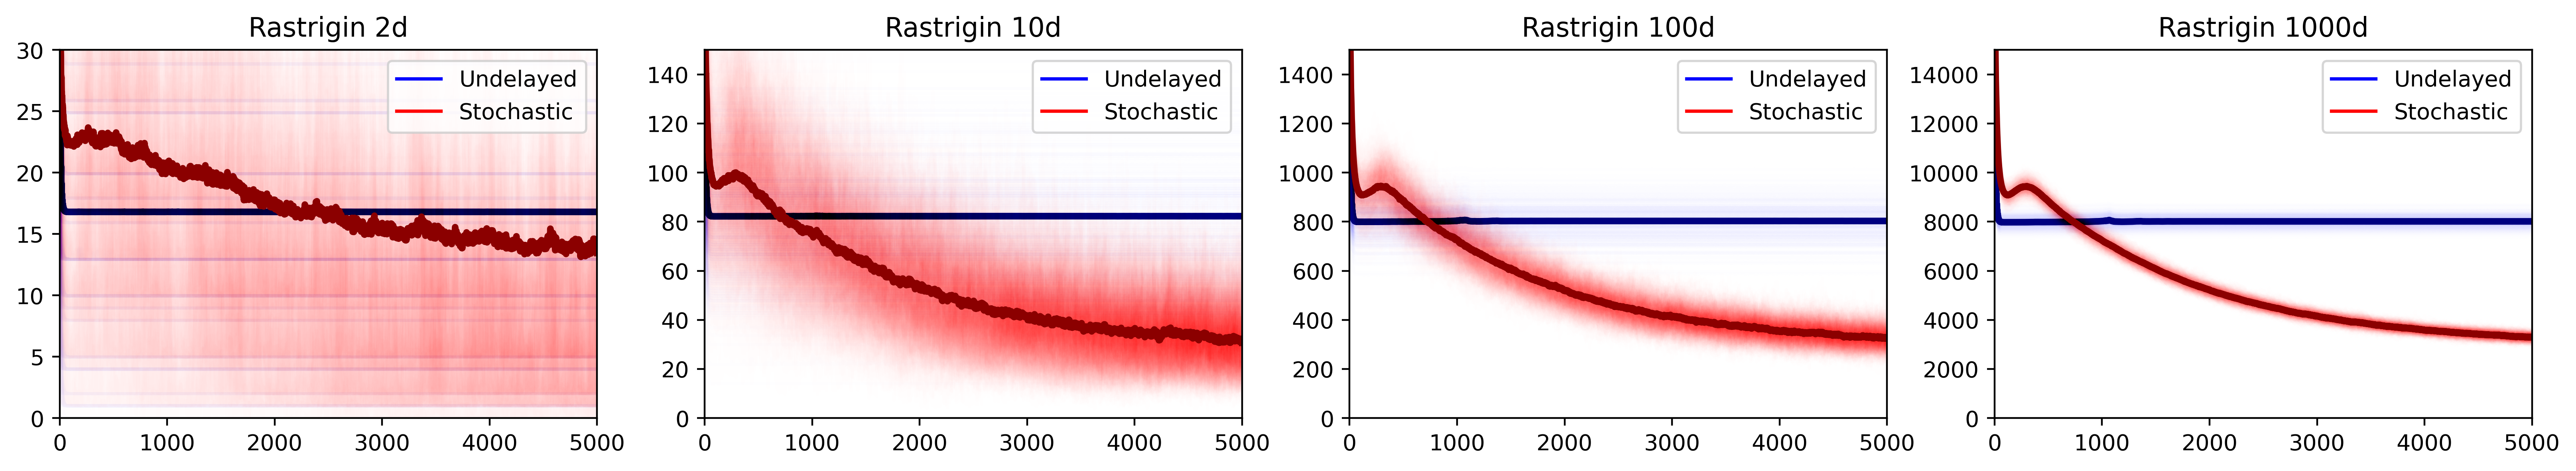

In [20]:
loss_name = "Rastrigin"
data_tags = {
    "Undelayed":"optimal_undel", 
    "Stochastic":"optimal_stochL1"
}
ylimits = [(0,15*d) for d in [2,10,100,1000]]
legend_locs = ["upper right"] * 4

plot_time_loss_all(loss_name, data_tags, legend_locs, pointwise=True, ylimits=ylimits)

plt.savefig(f"Plots/{loss_name}_time_loss.jpg", bbox_inches='tight')
plt.show()

## Rosenbrock

Data/Rosenbrock2d_optimal_undel.dat parameters: {'learning_rate': 3.94647350971932, 'lr_type': 'const'}
Data/Rosenbrock2d_optimal_stochL1.dat parameters: {'learning_rate': 3.57905263157895, 'lr_type': 'const'}
Data/Rosenbrock10d_optimal_undel.dat parameters: {'learning_rate': 0.566837845876878, 'lr_type': 'const'}
Data/Rosenbrock10d_optimal_stochL1.dat parameters: {'learning_rate': 0.421947368421053, 'lr_type': 'const'}
Data/Rosenbrock100d_optimal_undel.dat parameters: {'learning_rate': 0.329639308828399, 'lr_type': 'const'}
Data/Rosenbrock100d_optimal_stochL1.dat parameters: {'learning_rate': 0.266178324489324, 'lr_type': 'const'}
Data/Rosenbrock1000d_optimal_undel.dat parameters: {'learning_rate': 0.310612039345774, 'lr_type': 'const'}
Data/Rosenbrock1000d_optimal_stochL1.dat parameters: {'learning_rate': 0.268033972561053, 'lr_type': 'const'}


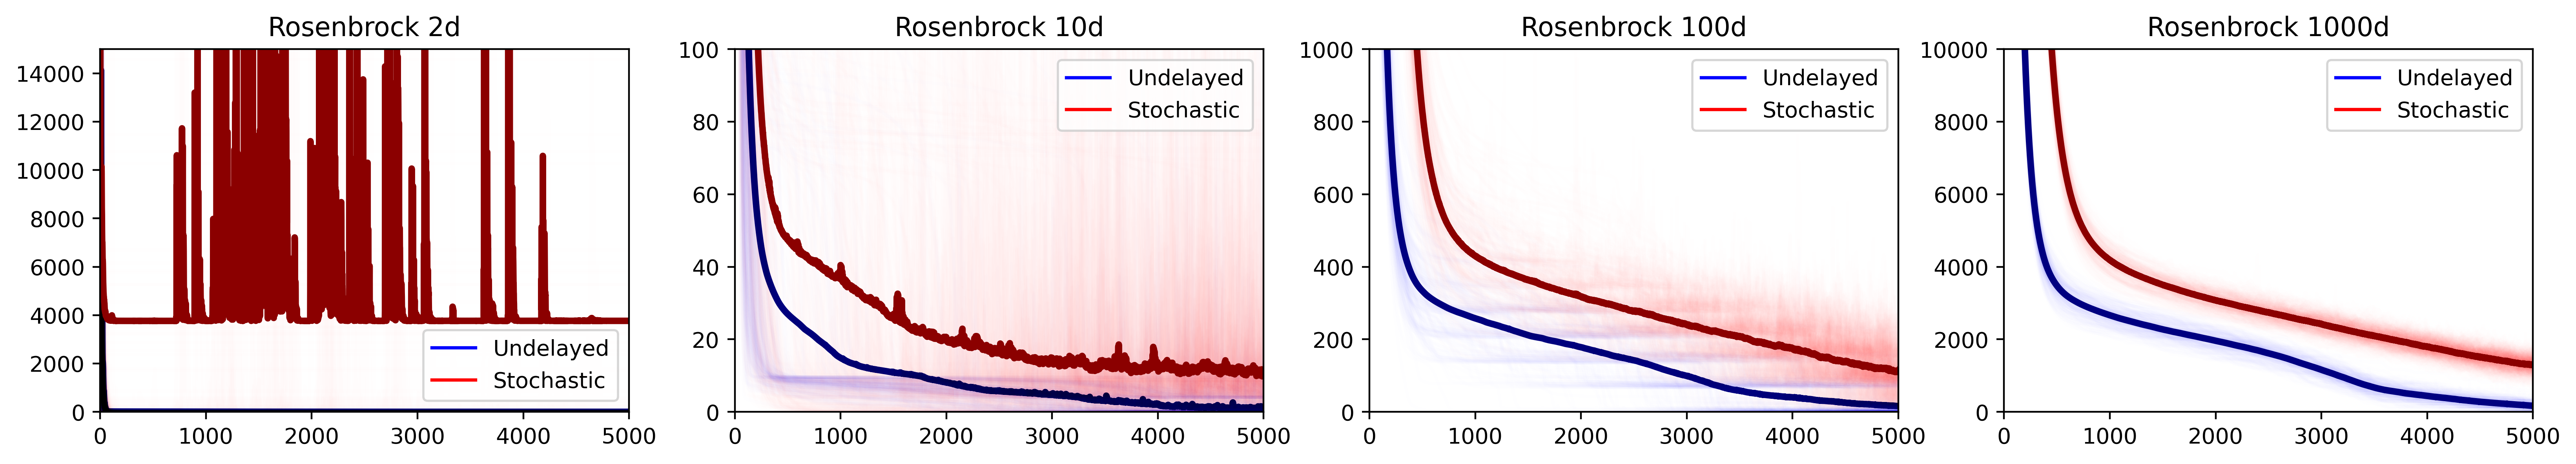

In [23]:
loss_name = "Rosenbrock"
data_tags = {
    "Undelayed":"optimal_undel", 
    "Stochastic":"optimal_stochL1"
}
ylimits = [(0,1.5e4),(0,1e2),(0,1e3),(0,1e4)]
legend_locs = ["lower right", "upper right", "upper right", "upper right"]

plot_time_loss_all(loss_name, data_tags, legend_locs, pointwise=True, ylimits=ylimits)

plt.savefig(f"Plots/{loss_name}_time_loss.jpg", bbox_inches='tight')
plt.show()

## Zakharov

Data/Zakharov2d_optimal_undel.dat parameters: {'learning_rate': 1.73889481723777, 'lr_type': 'const'}
Data/Zakharov2d_optimal_stochL1.dat parameters: {'learning_rate': 4.125375, 'lr_type': 'const'}
Data/Zakharov10d_optimal_undel.dat parameters: {'learning_rate': 3.97646574749106, 'lr_type': 'const'}
Data/Zakharov10d_optimal_stochL1.dat parameters: {'learning_rate': 2.76109419287542, 'lr_type': 'const'}
Data/Zakharov100d_optimal_undel.dat parameters: {'learning_rate': 2.41455172413793, 'lr_type': 'const'}
Data/Zakharov100d_optimal_stochL1.dat parameters: {'learning_rate': 0.391382192771158, 'lr_type': 'const'}
Data/Zakharov1000d_optimal_undel.dat parameters: {'learning_rate': 0.986621657063249, 'lr_type': 'const'}
Data/Zakharov1000d_optimal_stochL1.dat parameters: {'learning_rate': 5.17289655172414, 'lr_type': 'const'}


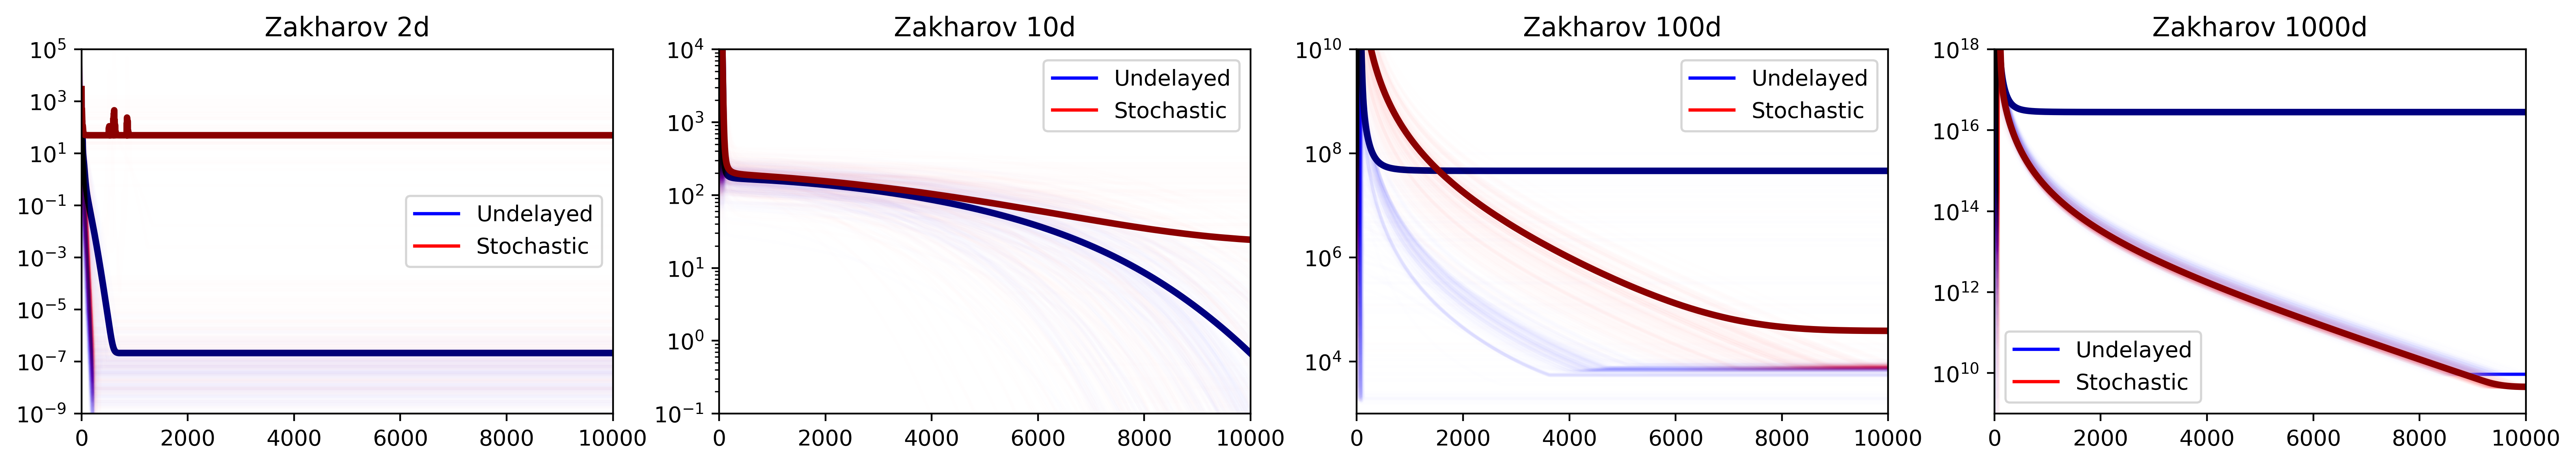

In [32]:
loss_name = "Zakharov"
data_tags = {
    "Undelayed":"optimal_undel", 
    "Stochastic":"optimal_stochL1"
}
ylimits = [(1e-9,1e5),(1e-1,1e4),(1e3,1e10),(1e9,1e18)]
legend_locs = ["best"] * 4

plot_time_loss_all(loss_name, data_tags, legend_locs, pointwise=True, ylimits=ylimits, logscale=True, 
                   reduce=250)

plt.savefig(f"Plots/{loss_name}_time_loss.jpg", bbox_inches='tight')
plt.show()

Data/Zakharov1000d_optimal_undel.dat parameters: {'learning_rate': 0.986621657063249, 'lr_type': 'const'}
Data/Zakharov1000d_optimal_stochL1.dat parameters: {'learning_rate': 5.17289655172414, 'lr_type': 'const'}
Data/Zakharov1000d_optimal_undel_inv.dat parameters: {'max_lr': 6.23629072573214, 'gamma': 0.596881995576396, 'p': 0.021857445184297, 'lr_type': 'inv'}
Data/Zakharov1000d_optimal_stochL1_inv.dat parameters: {'max_lr': 5.71110602270459, 'gamma': 0.351502577118679, 'p': 0.032566134123827, 'lr_type': 'inv'}
Data/Zakharov1000d_optimal_undel_sin2.dat parameters: {'max_lr': 2.75458156916142, 'min_lr': 0.665686088428621, 'step_size': 311.135786982933, 'lr_type': 'sin-2'}
Data/Zakharov1000d_optimal_stochL1_sin2.dat parameters: {'max_lr': 5.02040493251131, 'min_lr': 5.92992686451719, 'step_size': 942.536441097518, 'lr_type': 'sin-2'}
Data/Zakharov1000d_optimal_undel_tri2.dat parameters: {'max_lr': 2.09273472246977, 'min_lr': 5.60765894963322, 'step_size': 494.521071957496, 'lr_type': '

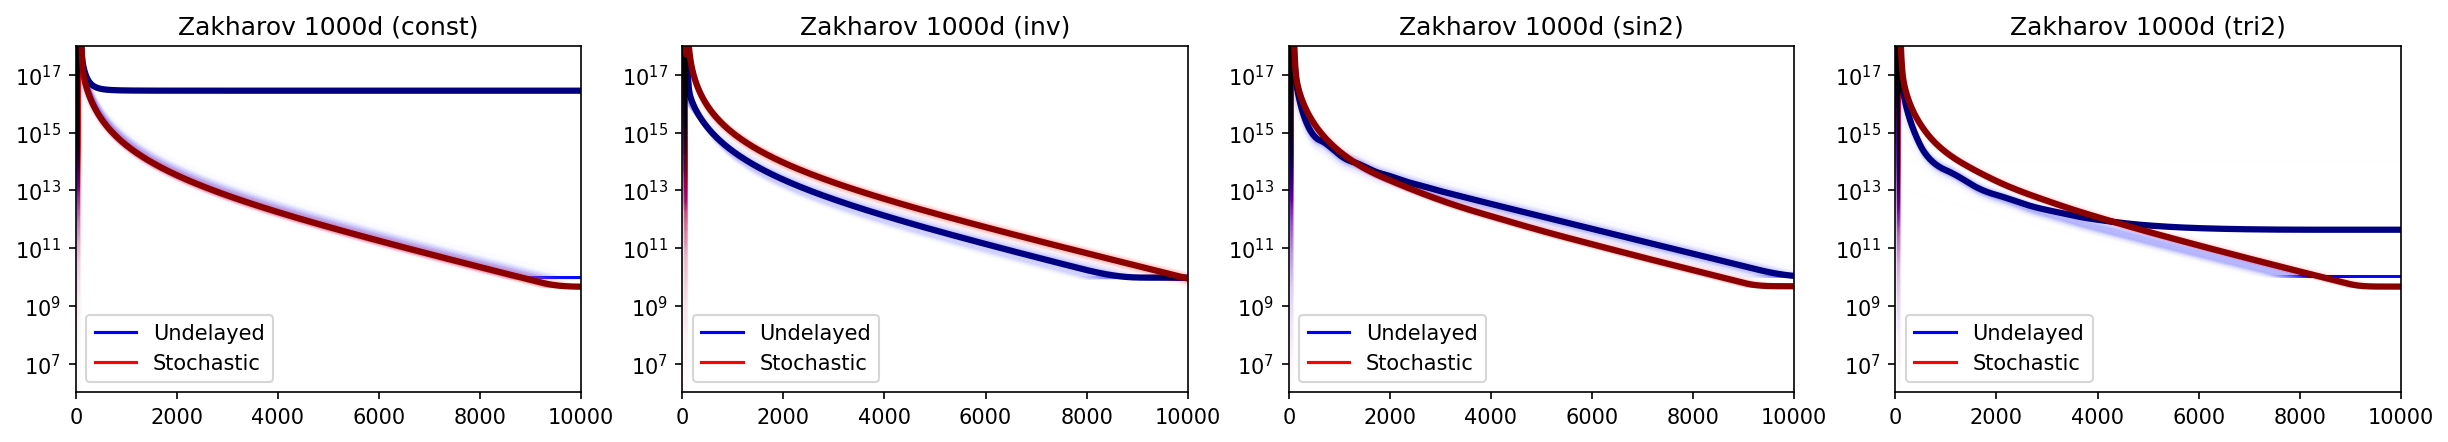

In [45]:
loss_name = "Zakharov"
dim = 1000
ylim = [1e6,1e18]
fig, axes = plt.subplots(1, 4, dpi=150, figsize=(20,3))
axes = axes.ravel()

data_tags = {
    "Undelayed":"optimal_undel", 
    "Stochastic":"optimal_stochL1"
}

ax = plot_time_loss(loss_name, dim, data_tags, legend_loc="lower left", ax=axes[0], reduce=250)
format_plot(ax, ylim=ylim, title=f"{loss_name} {dim}d (const)", logscale=True)

lr_types = ["inv", "sin2", "tri2"]
for i, lr_type in enumerate(lr_types):
    lr_data_tags = {k:v+f"_{lr_type}" for k, v in data_tags.items()}
    ax = plot_time_loss(loss_name, dim, lr_data_tags, legend_loc="lower left", ax=axes[i+1], reduce=250)
    format_plot(ax, ylim=ylim, title=f"{loss_name} {dim}d ({lr_type})", logscale=True)
    
plt.savefig(f"Plots/{loss_name}_time_loss_lrs.jpg", bbox_inches='tight')
plt.show()

# Combined

Data/Ackley1000d_optimal_undel.dat parameters: {'learning_rate': 0.087579721240169, 'lr_type': 'const'}
Data/Ackley1000d_optimal_stochL1.dat parameters: {'learning_rate': 1.40918128594683, 'lr_type': 'const'}
Data/Ackley1000d_stochL1_stochL1_500.dat parameters: {'learning_rate': 1.40918128594683, 'lr_type': 'const'}
Data/Ackley1000d_stochL1_stochL1_1000.dat parameters: {'learning_rate': 1.40918128594683, 'lr_type': 'const'}
Data/Ackley1000d_stochL1_stochL1_2000.dat parameters: {'learning_rate': 1.40918128594683, 'lr_type': 'const'}
Data/Ackley1000d_stochL1_stochL1_4000.dat parameters: {'learning_rate': 1.40918128594683, 'lr_type': 'const'}
Data/Zakharov1000d_optimal_undel.dat parameters: {'learning_rate': 0.986621657063249, 'lr_type': 'const'}
Data/Zakharov1000d_optimal_stochL1.dat parameters: {'learning_rate': 5.17289655172414, 'lr_type': 'const'}
Data/Zakharov1000d_stochL1_stochL1_1000.dat parameters: {'learning_rate': 5.17289655172414, 'lr_type': 'const'}
Data/Zakharov1000d_stochL1_

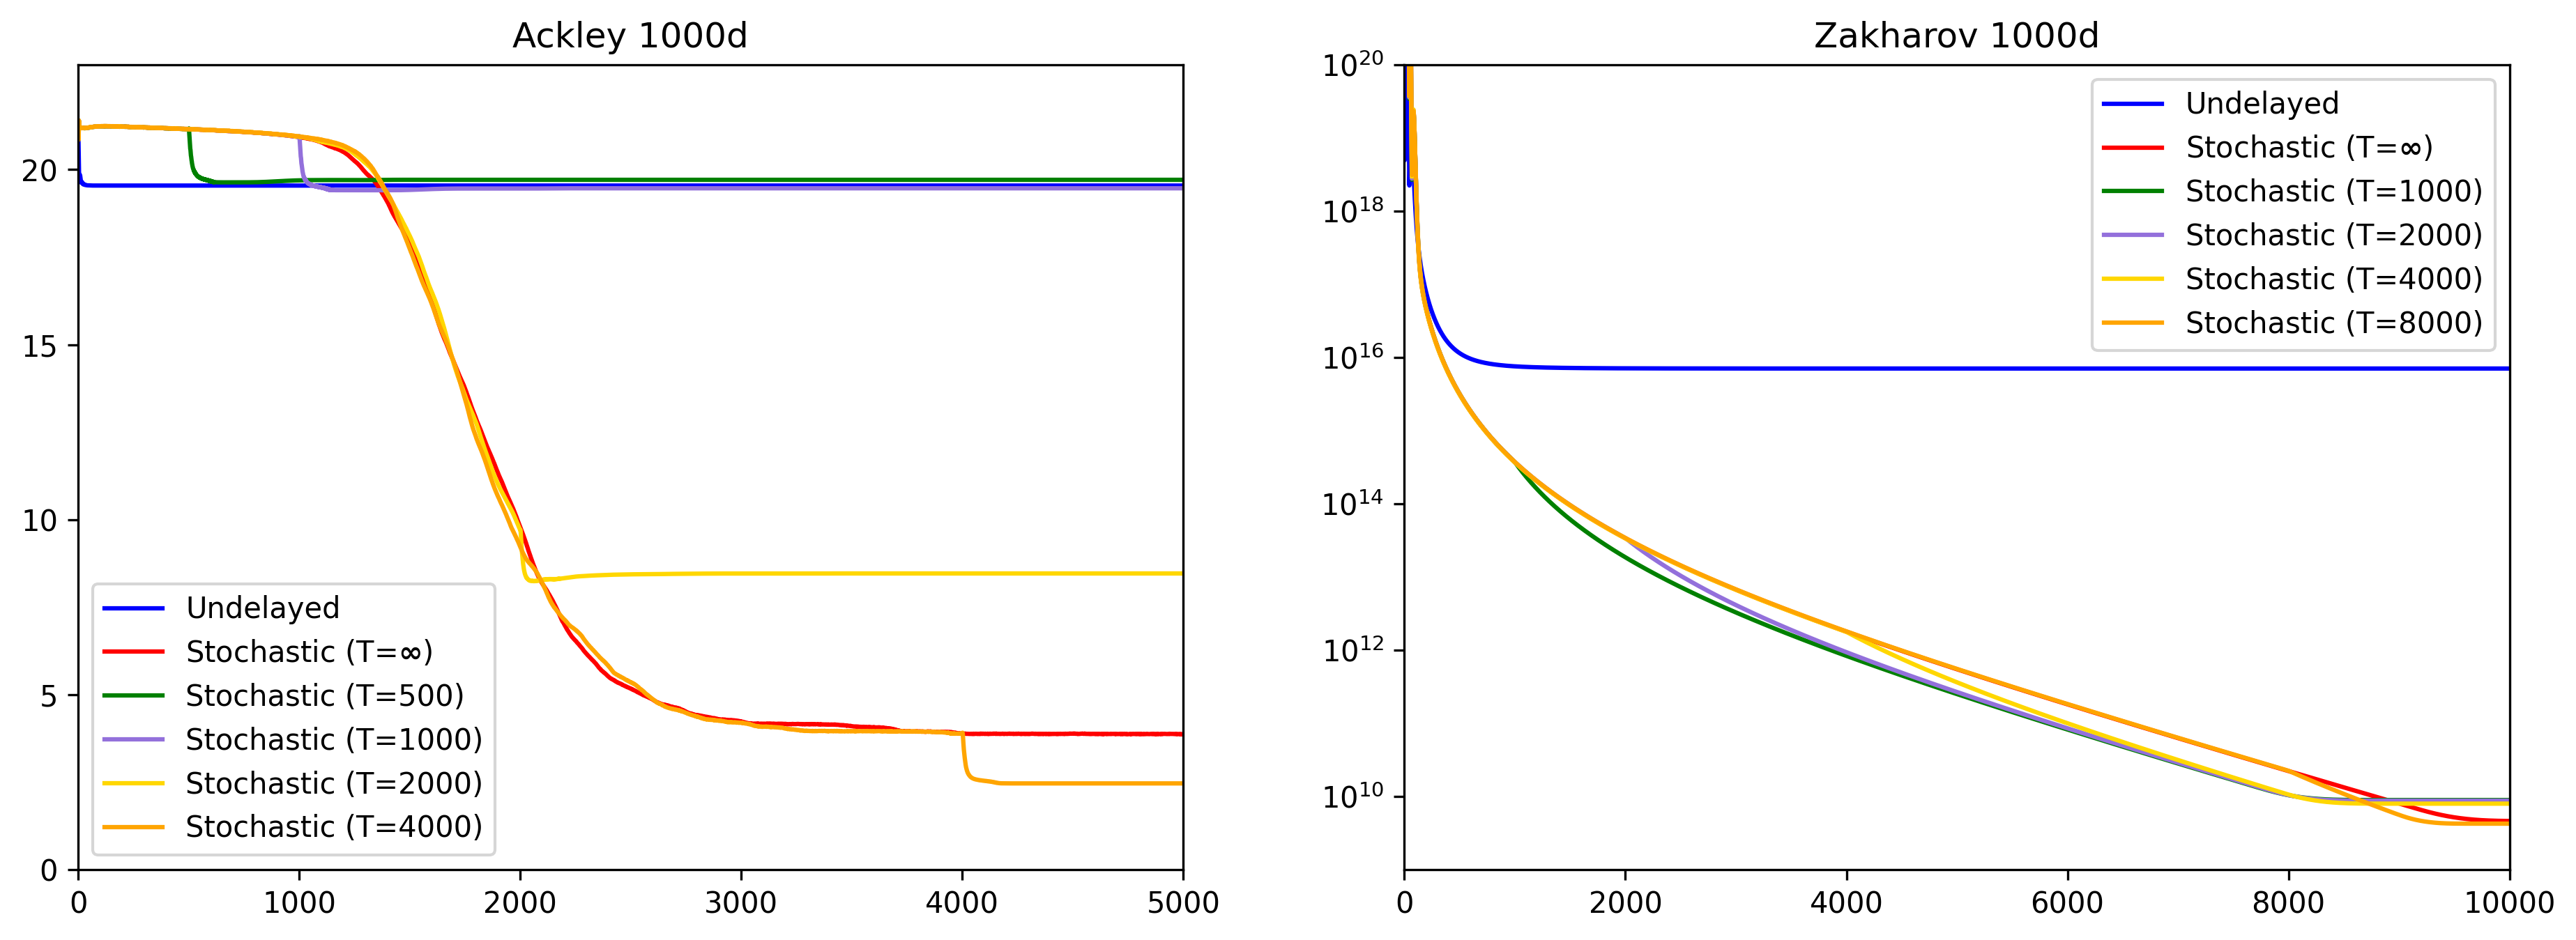

In [9]:
ack_data_tags = {
    "Undelayed": "optimal_undel", 
    r"Stochastic (T=$\mathbf{\infty}$)": "optimal_stochL1", 
    "Stochastic (T=500)": "stochL1_stochL1_500", 
    "Stochastic (T=1000)": "stochL1_stochL1_1000", 
    "Stochastic (T=2000)": "stochL1_stochL1_2000", 
    "Stochastic (T=4000)": "stochL1_stochL1_4000"
}
zak_data_tags = {
    "Undelayed": "optimal_undel", 
    r"Stochastic (T=$\mathbf{\infty}$)": "optimal_stochL1", 
    "Stochastic (T=1000)": "stochL1_stochL1_1000", 
    "Stochastic (T=2000)": "stochL1_stochL1_2000", 
    "Stochastic (T=4000)": "stochL1_stochL1_4000", 
    "Stochastic (T=8000)": "stochL1_stochL1_8000"
}

fig, axes = plt.subplots(1, 2, dpi=300, figsize=(15,5))

plot_time_loss("Ackley", 1000, ack_data_tags, pointwise=False, logscale=False, ax=axes[0])
axes[0].set_ylim([0,23])
plot_time_loss("Zakharov", 1000, zak_data_tags, pointwise=False, logscale=True, ax=axes[1])
axes[1].set_ylim([1e9,1e20])
plt.savefig("Plots/Ackley_Zakharov_time_loss_drop.jpg", bbox_inches='tight')
plt.show()

Data/Ackley1000d_optimal_undel.dat parameters: {'learning_rate': 0.087579721240169, 'lr_type': 'const'}
Data/Ackley1000d_optimal_stochL1.dat parameters: {'learning_rate': 1.40918128594683, 'lr_type': 'const'}
Data/Ackley1000d_stochL1_stochL2.dat parameters: {'learning_rate': 1.40918128594683, 'lr_type': 'const'}
Data/Ackley1000d_stochL1_stochL5.dat parameters: {'learning_rate': 1.40918128594683, 'lr_type': 'const'}
Data/Ackley1000d_stochL1_stochL10.dat parameters: {'learning_rate': 1.40918128594683, 'lr_type': 'const'}
Data/Zakharov1000d_optimal_undel.dat parameters: {'learning_rate': 0.986621657063249, 'lr_type': 'const'}
Data/Zakharov1000d_optimal_stochL1.dat parameters: {'learning_rate': 5.17289655172414, 'lr_type': 'const'}
Data/Zakharov1000d_stochL1_stochL2.dat parameters: {'learning_rate': 5.17289655172414, 'lr_type': 'const'}
Data/Zakharov1000d_stochL1_stochL5.dat parameters: {'learning_rate': 5.17289655172414, 'lr_type': 'const'}
Data/Zakharov1000d_stochL1_stochL10.dat paramete

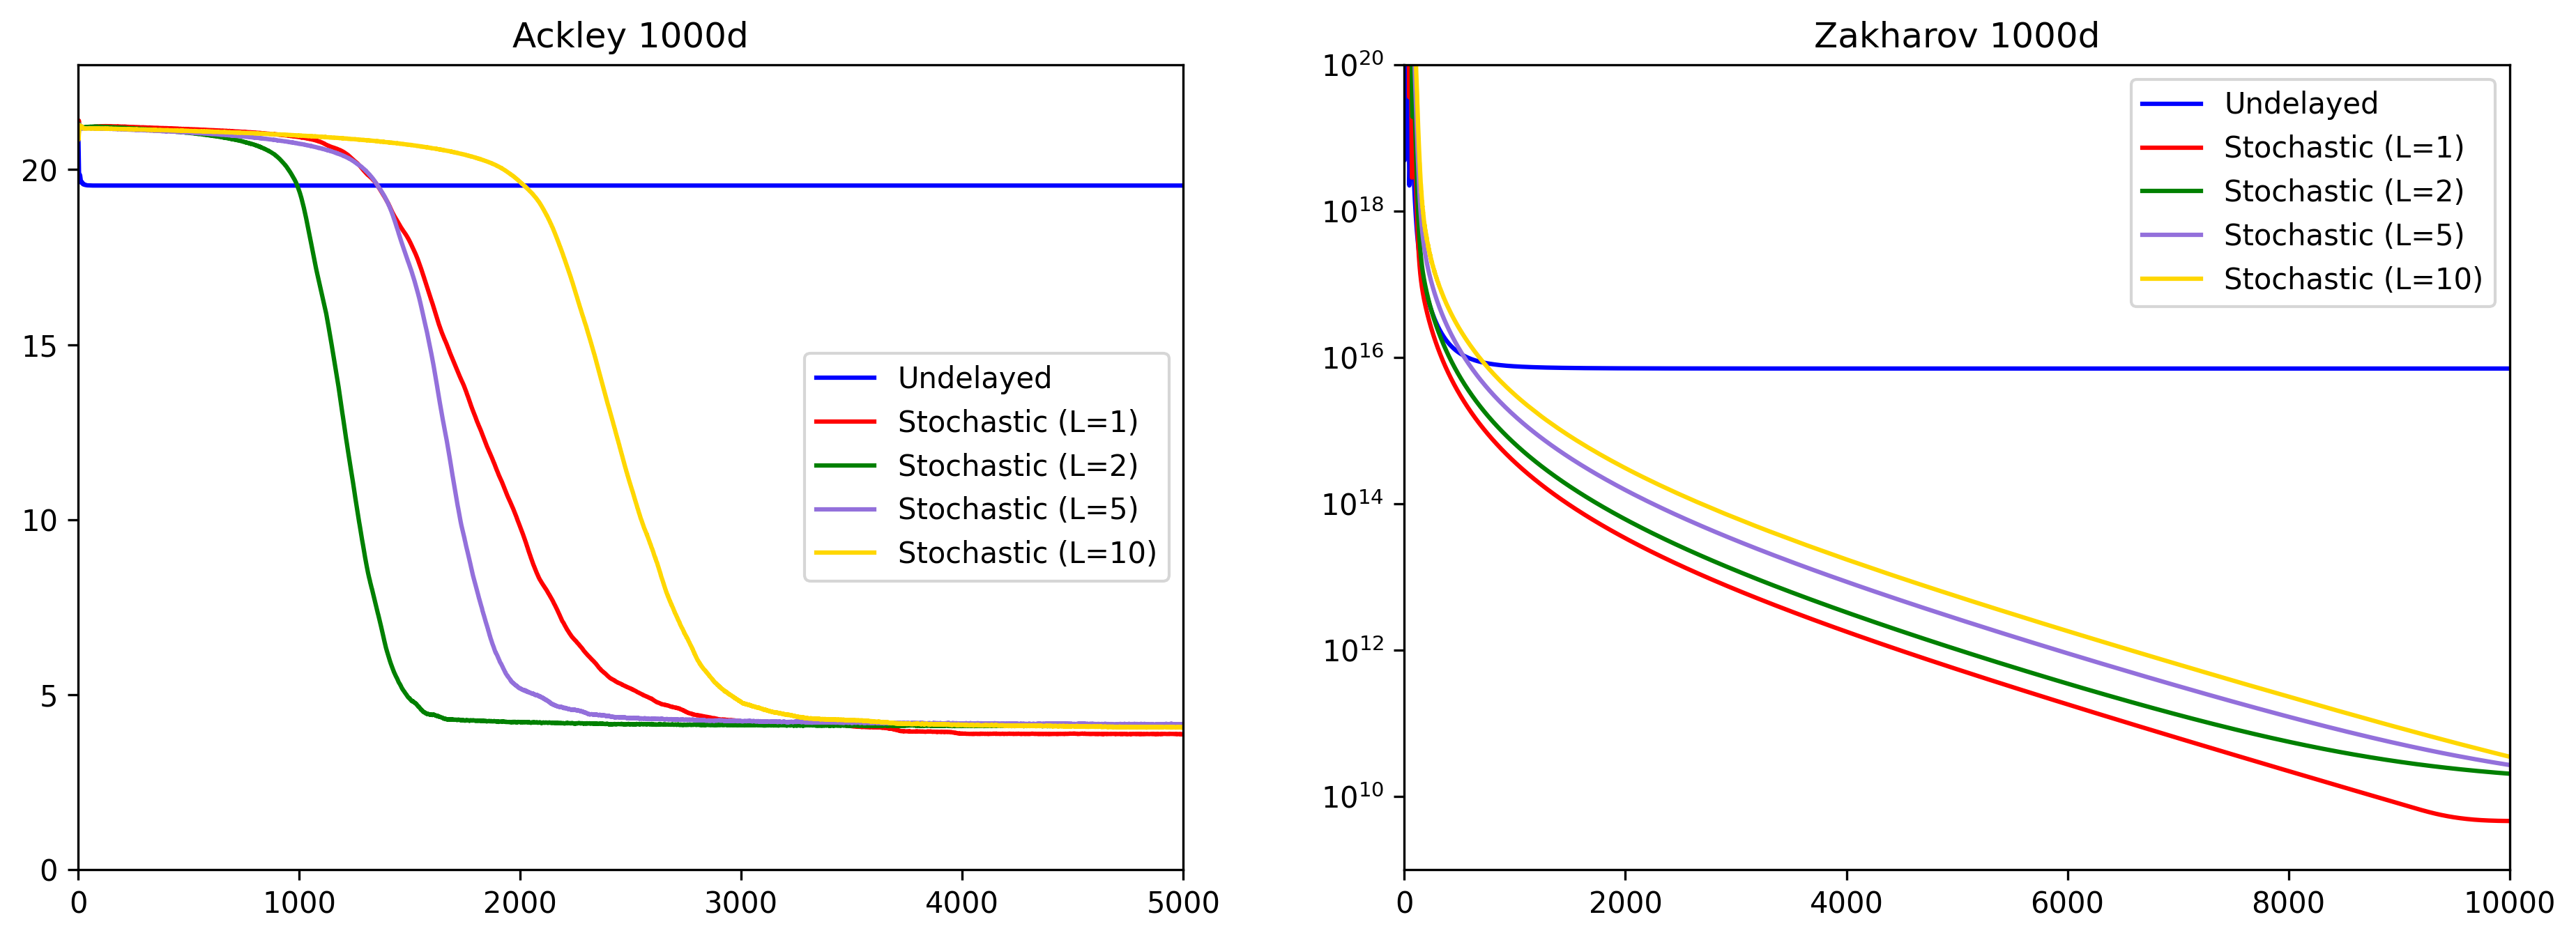

In [10]:
data_tags = {
    "Undelayed": "optimal_undel", 
    "Stochastic (L=1)": "optimal_stochL1", 
    "Stochastic (L=2)": "stochL1_stochL2", 
    "Stochastic (L=5)": "stochL1_stochL5", 
    "Stochastic (L=10)": "stochL1_stochL10",
}

fig, axes = plt.subplots(1, 2, dpi=300, figsize=(15,5))

plot_time_loss("Ackley", 1000, data_tags, pointwise=False, logscale=False, ax=axes[0])
format_plot(axes[0], ylim=[0,23])
plot_time_loss("Zakharov", 1000, data_tags, pointwise=False, logscale=True, ax=axes[1])
format_plot(axes[1], ylim=[1e9,1e20])
plt.savefig("Plots/Ackley_Zakharov_time_loss_Ls.jpg", bbox_inches='tight')
plt.show()